# Possibly the World's Worst Cipher

This morning as I was waking up from anxious dreams, I discovered in bed that the Vignere cipher could be changed into a monstrous, verminous bug. I'll refer to the cipher described here as the 
*Samsa cipher* for the sake of convenience. If this kind of cipher has been described before and has an established name, I will update this notebook with due citations.

The Samsa cipher takes two secret keywords as inputs. With these keywords, a positional grid is constructed with the two keywords written along its axes, and the message is placed inside the resulting grid like so:

```
  A P P L E
S m y   s u 
A p e r   s
U e c r e t
C   m e s s
E a g e . 
```
To encrypt a message that is longer than the grid has room for, one simply repeats the grid like so:

```
  A P P L E
S m y   s l
A i g t l y
U   l o n g
C e r   s u      
E p e r   s
S e c r e t
A   m e s s
U s a g e .
C
E
```
Once the message has been written inside the grid, the message is encrypted using the following procedure:
- For each letter *L* in the message, let (*X*,*Y*) be the pair of keyword letters that corrsespond *L*'s position in the grid
  - i.e. the position of the first 'm' in the above examples corresponds to the pair (A,S)
- Apply the double rotation rotY(rotX(L)) to encrypt *L*
  - "rotX()" here is the Ceaser cipher in which 'A' is encripyted as *X*

Deciphering the text requires simply the reversal of each double rotation.

With the aid of a [Vignere square](https://www.simonsingh.net/The_Black_Chamber/vigenere_square_tool.html) or perhaps a [cipher disk](https://en.wikipedia.org/wiki/Cipher_disk) with three alphabets, one could imaginably apply and reverse the cipher by hand with some effort. The resulting message is very difficult to crack if one does not know which words comprise the grid, however. Hypothetically, this approach could make use of *N* keywords and thus *N* rotations to add further degrees of complexity. For instance, three words could be passed to the cipher, and a 3-dimensional grid (think a tensor) would be constructed to write the message in, and one would carry out the procedure described above using the corresponding triplets of keyword characters.

The Samsa cipher can be thought of as a generalization of the Vignere cipher. The usual Vignere cipher results from using "A" as either keyword. Moreover, it can be considered equivalent to the Vignere cipher, where the grid serves to generate a "keyword" of length *M*x*N* where *M* and *N* are the lengths of the first and second keywords, respectively. The length and lack of discernable pattern in the "keyword" generated by the grid are what make this variation of the cipher particularly effective, although it is in theory susceptible to the same [cracking techniques](https://www.simonsingh.net/The_Black_Chamber/crackingprinciple.html) used by Charles Babbage and others to crack the Vignere cipher.

## Basic Rotation Ciphers

These will be the basic building blocks of the Samsa cipher.

In [1]:
def rotx(phrase, key):
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    start = alphabet.index(key.upper())
    phrase = phrase.upper()
    secret = ''.join(alphabet[(start + alphabet.index(p)) % len(alphabet)] if p in alphabet else p for p in phrase)
    return secret

In [2]:
def unrotx(phrase, key):
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    key = alphabet[-alphabet.index(key.upper())]
    return rotx(phrase, key)

In [3]:
rotx('my super secret message.', 'n')

'ZL FHCRE FRPERG ZRFFNTR.'

In [4]:
unrotx('zl fhcre frperg zrffntr.', 'n')

'MY SUPER SECRET MESSAGE.'

## Double Rotations

In [5]:
def rotxy(phrase, key1, key2):
    return rotx(rotx(phrase, key1), key2)

In [6]:
def unrotxy(phrase, key1, key2):
    return unrotx(unrotx(phrase, key2), key1)

In [7]:
rotxy('my super secret message.', 'a', 's')

'EQ KMHWJ KWUJWL EWKKSYW.'

In [8]:
unrotxy('eq kmhwj kwujwl ewkksyw.', 'a', 's')

'MY SUPER SECRET MESSAGE.'

## The Samsa 2-Cipher

This is the basic implementation of the Samsa cipher in which two keywords are used.

In [9]:
def samsa2_encrypt(phrase, keyphrase1, keyphrase2):
    k1 = 0
    k2 = 0
    secret = []
    for i in range(len(phrase)):
        secret.append(rotxy(phrase[i], keyphrase1[k1], keyphrase2[k2]))
        k1 = (k1 + 1) % len(keyphrase1)
        if i>0 and k1==0:
            k2 = (k2 + 1) % len(keyphrase2)
    return ''.join(secret)

In [10]:
def samsa2_decrypt(phrase, keyword1, keyword2):
    k1 = 0
    k2 = 0
    secret = []
    for i in range(len(phrase)):
        secret.append(unrotxy(phrase[i], keyword1[k1], keyword2[k2]))
        k1 = (k1 + 1) % len(keyword1)
        if i>0 and k1==0:
            k2 = (k2 + 1) % len(keyword2)
    return ''.join(secret)

In [11]:
samsa2_encrypt('my super secret message.', 'apple', 'sauce')

'EF VQPTG WYLAJR DVFYEZX.'

In [12]:
samsa2_decrypt('EF VQPTG WYLAJR DVFYEZX.', 'apple', 'sauce')

'MY SUPER SECRET MESSAGE.'

In [13]:
samsa2_encrypt('my slightly longer super secret message.', 'apple', 'sauce')

'EF VHIVWEPS UTLIVI YYIXG KLJUAT BPWMJPJ.'

In [14]:
samsa2_decrypt('ef vhivweps utlivi yyixg kljuat bpwmjpj.', 'apple', 'sauce')

'MY SLIGHTLY LONGER SUPER SECRET MESSAGE.'

## Quick Visual Analysis

Although this is very rudimentary, looking at the frequency distribution of the letters in Samsa-encrypted messages will help us get an initial idea of how it compares to other ciphers. One should experiment with a Vignere cracking technique to get a better idea of the Samsa cipher's integrity.

As a rule of thumb, a more uniform distribution indicates a certain strength against frequency analysis techniques.

In [15]:
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [16]:
# Grabbing the text of a Wikipedia article on Jellyfish for testing
response = requests.get(url='https://en.wikipedia.org/wiki/Jellyfish')
soup = BeautifulSoup(response.content)
jellyfish = ''.join(p.text.replace('\n',' ') for p in soup.select('p'))

In [17]:
def letter_hist(text):
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    letters = sorted(x for x in list(text.upper()) if x in alphabet)
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(9,6))
    plt.hist(letters, bins=len(alphabet))
    plt.title('Letter Frequency', pad=20)
    ax.set_ylabel('Count', labelpad=20)
    plt.show()

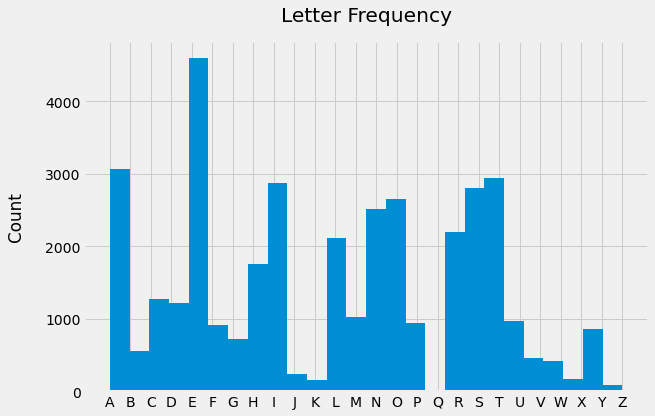

In [18]:
# The text itself
letter_hist(jellyfish)

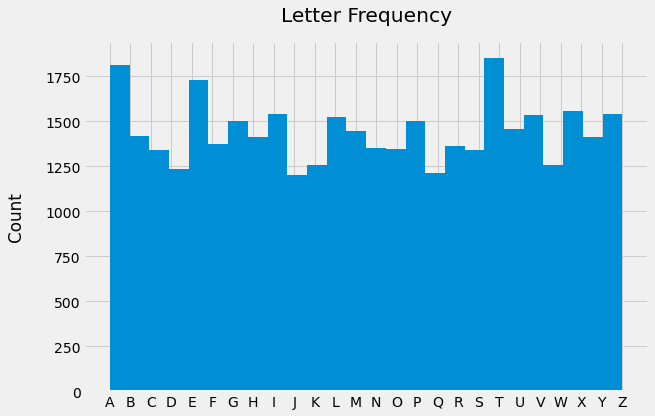

In [19]:
# The Samsa-encrypted text
letter_hist(samsa2_encrypt(jellyfish, 'wikipedia', 'jellyfish'))


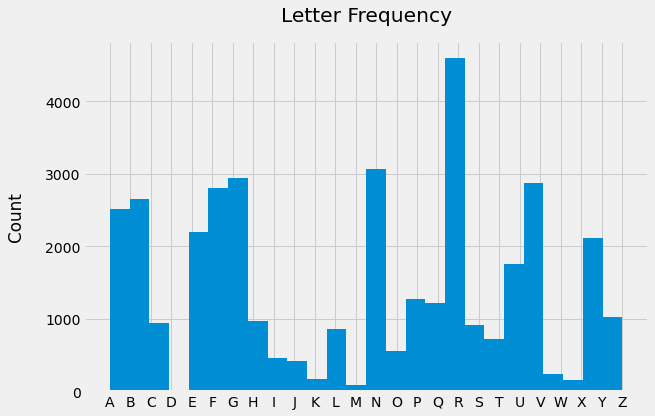

In [20]:
# Compare to ROT13
letter_hist(rotx(jellyfish, 'n'))

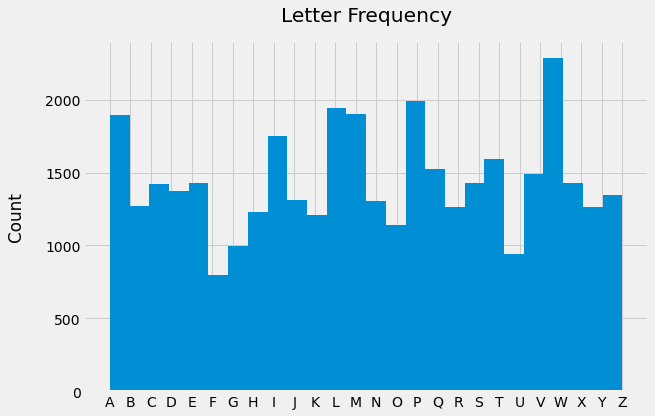

In [21]:
# Compare to Vignere
letter_hist(samsa2_encrypt(jellyfish, 'wikipediajellyfish', 'a')) # 'a' doesn't shift anything

## A Bigger, Better Super-Cipher

Let's do that thing I mentioned up top where we generalize this technique to take any number of words as a keyphrase. This is not something that I would expect anyone in their right mind to attempt by hand, but it is exceedingly difficult to crack.

In [22]:
# Applies an arbitrary number of rotations on the text
def rotxyz(text, keys):
    for key in keys:
        text = rotx(text, key)
    return text

def unrotxyz(text, keys):
    for key in keys:
        text = unrotx(text, key)
    return text

# The fullly generalized Samsa cipher
def samsaN_encrypt(text, keyphrase):
    keywords = keyphrase.split()
    indices = [0 for k in keywords]
    secret = []
    for i in range(len(text)):
        secret.append(rotxyz(text[i],[keyword[i] for keyword,i in zip(keywords,indices)]))
        for j in range(len(indices)):
            if indices[j] == len(keywords[j])-1:
                indices[j] = 0
                continue
            indices[j] = indices[j] + 1
            break
    return ''.join(secret)

def samsaN_decrypt(text, keyphrase):
    keywords = keyphrase.split()
    indices = [0 for k in keywords]
    secret = []
    for i in range(len(text)):
        secret.append(unrotxyz(text[i],[keyword[i] for keyword,i in zip(keywords,indices)]))
        for j in range(len(indices)):
            if indices[j] == len(keywords[j])-1:
                indices[j] = 0
                continue
            indices[j] = indices[j] + 1
            break
    return ''.join(secret)

In [23]:
text = 'One morning as Gregor Samsa was waking up from anxious dreams he discovered that in bed he had been changed into a monstrous verminous bug'
keyphrase = 'a medium sized message that should be difficult enough to crack'
samsaN_encrypt(text, keyphrase)

'SJZ YSLZTDI LV NKPWWY QQBZG TPO JSOEZK CJ IMIL DVXHSKA CPHPTC IK NIKTKDEINL SYWH AR WRP KZ JBJ LEWE KHRWORC EBGG W ZAEVOJYDG NMRLMDWTJ WBF'

In [24]:
cryptext = 'sjz yslztdi lv nkpwwy qqbzg tpo jsoezk cj imil dvxhska cphptc ik niktkdeinl sywh ar wrp kz jbj lewe khrworc ebgg w zaevojydg nmrlmdwtj wbf'
samsaN_decrypt(cryptext, keyphrase)

'ONE MORNING AS GREGOR SAMSA WAS WAKING UP FROM ANXIOUS DREAMS HE DISCOVERED THAT IN BED HE HAD BEEN CHANGED INTO A MONSTROUS VERMINOUS BUG'

In [25]:
# You should even be able to use a text as its own keyphrase (although useless)
samsaN_encrypt(text, text)

'ZXF YRHCOZR HY SCGLSM UTRWV DYW QZIXRJ RL BMAK OOXZLQF UZBWZI NS HYHIHNNGSI CHPH QU KMC RF UEN BJII LHDPZFD LPMU W NGKOGTPMN GPBNVZRKH NFI'

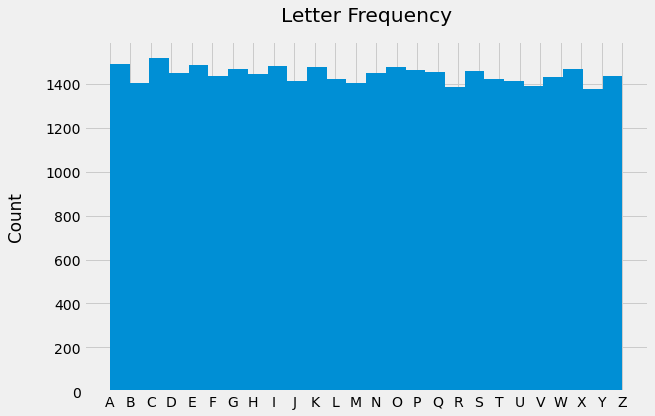

In [26]:
letter_hist(samsaN_encrypt(jellyfish, text))

That looks great. Nearly flat.

How long is the "keyword" generated by the algorithm? That will determine the minimum number of factors that would need to be checked in order to find the length of the "keyword" using the Vignere cracking tool [here](https://www.simonsingh.net/The_Black_Chamber/vigenere_cracking_tool.html). The total lengths of the words that are passed to the cipher as keywords will also determine how many frequency distributions will need to be analyzed to find a match once the length of the keyword is determined.

In [27]:
import math

In [28]:
def analyze_key(key):
    key_len = math.prod([len(k) for k in key.split()])
    fmt_key_len = f'{key_len:.1e}'
    print(f'One would need to check {fmt_key_len} factors and at least {len(key)} frequency distributions to crack this.')

In [29]:
analyze_key(text)

One would need to check 6.0e+14 factors and at least 138 frequency distributions to crack this.


## Even Bigger Still

In [these examples of RSA keys](https://www.thedigitalcatonline.com/blog/2018/04/25/rsa-keys/), a private key can occupy upwards of 1600 characters of text. While I understand that length in units of text characters is not how the length of an RSA key is measured, we'll use it here anyway. Let's use a comparable chunk of text as a key set to encrypt the Jellyfish article.

In [30]:
kafka = 'One morning as Gregor Samsa was waking up from anxious dreams he discovered that in bed he had been changed into a monstrous verminous bug He lay on his armourhard back and saw as he lifted his head up a little his brown arched abdomen divided up into rigid bowlike sections From this height the blanket just about ready to slide off completely could hardly stay in place His numerous legs pitifully thin in comparison to the rest of his circumference flickered helplessly before his eyes Whats happened to me he thought It was no dream His room a proper room for a human being only somewhat too small lay quietly between the four wellknown walls Above the table on which an unpacked collection of sample cloth goods was spread out Samsa was a traveling salesman hung the picture which he had cut out of an illustrated magazine a little while ago and set in a pretty gilt frame It was a picture of a woman with a fur hat and a fur boa She sat erect there lifting up in the direction of the viewer a solid fur muff into which her entire forearm disappeared Gregors glance then turned to the window The dreary weather the rain drops were falling audibly down on the metal window ledge made him quite melancholy Why don’t I keep sleeping for a little while longer and forget all this foolishness he thought But this was entirely impractical for he was used to sleeping on his right side and in his present state he couldnt get himself into this position No matter how hard he threw himself onto his right side he always rolled again onto his back He must have tried it a hundred times closing his eyes so that he would not have to see the wriggling legs and gave up only when he began to feel a light dull pain in his side which he had never felt before'

Around 1700 characters of text, 1400 when you remove spaces.

Source: [The Metamorphosis, Kafka Online](https://www.kafka-online.info/the-metamorphosis.html)

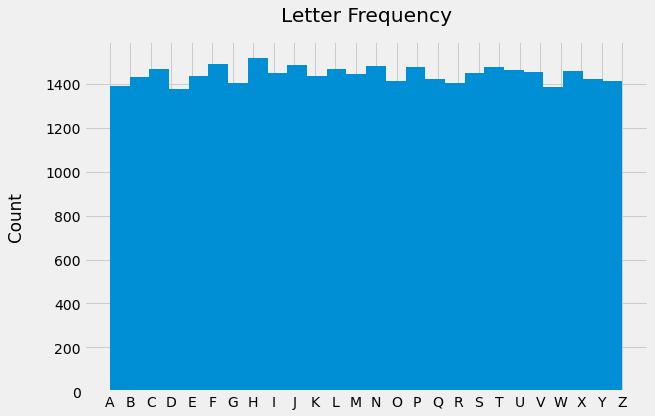

In [31]:
letter_hist(samsaN_encrypt(jellyfish, kafka))

In [32]:
analyze_key(kafka)

One would need to check 1.3e+189 factors and at least 1750 frequency distributions to crack this.


*That's pretty nice.*